The most used measurements of goalie performance in Hockey are limited at best. For example, the save shot percentage, measured as the ratio of saved shots over the total amount of shots in a game, does not take the shots" charateristics into consideration, leading to overestimating the performances by goalies that play in teams with great defensive skills. Shots that originate from close from the goalie a for example much harder to stop than shots from a bigger distance.

One way to solve this issue is to use the characteristics of a shot (distance from the goalie, type of shot, whether it is a rebound, etc.) to make a prediction on its probability to be a goal. The higher the probability, the more dangerous the shot. Summing these probabilities over a game or a season gives the expected amound of goals for the average goalie in the league. If your favorite goalie gave less goals than that, than he did better than the league average. And the lower this number, the better he did.

In this notebook, we produce such a ranking. We first use the shots data from the [*MoneyPuck* database](http://moneypuck.com/data.htm) to build a prediction machine for the NHL shots' probability to be a goal. Unsurprisingly, we use a gradient boosting algorithm from the xgboost library. We then produce an NHL goalies ranking based on their difference between the amount of goals they gave in a season and the amount of goals the average NHL goalie would have let if he received the very same shots.

# Hypothesis

We must warn the reader that the validity of our ranking is based on some assumptions, the most important one being that the goalies do not have an impact on the quality of the shots they receive. It is not unreasonable to assume that it is not the case: goalies do to passively wait for shots, they intercept passes, intimidate their opponents with their reputation/confidence and often make passes. They also try to deviate the shots outside the dangerous zones or to freeze them in order to avoid dangerous rebounds. One way to alleviate this concern is to hypothesize that while goalies do have an impact on the shots they receive, their ability to do so is tighly correlated with their talent to stop these shots. In that case, our method would simply understimate the difference between the good and the bad goalies, but not affect their ranking.

We explore the validity of this hypothesis in the section "Robustness" (WORK IN PROGRESS).

# Setting up the environment and loading the data

We first load our environment, working with the industry standard modules. The flat file can also be accessed from this [link](http://peter-tanner.com/moneypuck/downloads/shots_2007-2018.zip).

In [1]:
######################
# Environment        #
######################

import warnings
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg 
import seaborn as sns
from scipy.stats import uniform, randint
from xgboost import XGBClassifier
from sklearn.impute import SimpleImputer
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.compose import make_column_transformer

warnings.filterwarnings("ignore")

######################
# Dataframe          #
######################

shots = pd.read_csv("/kaggle/input/shots-20072018/shots_2007-2018.csv")
shots.head(15)

# Loading the picture for the heatmap
rink = mpimg.imread("/kaggle/input/hockey-rinks/hockey_rink_half.jpg")

# Data work
This part does minor feature engineering and identifies the categorical and numerical features. It is worth noting that we rename goalies to include the season in their name (e.g. "Carey Price_2018"). We do the same thing for the shooting player and its team. Not only this will make it easier to compute the season performances, it makes sense to think that the teams, players and goalies are not static, but evolve over time. To put it simply: I'd rather receive a shot by the Brandon Gallagher from 2012 than by today's Gallagher.

We also include the squared terms of shot distance and angle, in order to help the model attribute more danger to shots from a medium distance, or more from short and long distance only. On could argue that it is a good strategy for traditionnal models like a linear regression, but that it is not that useful for tree-based models (esp. boosting models). It is something that we could test some day.

More importantly, we avoid using features that would predict too well the goalie or the defending team to train the model. This way, we get the dangerousness of a shot given an average NHL goalie, which is the element that we will need for the ranking.

In [2]:
######################
# Light data work    #
######################

# Only keeping post-lockout seasons
shots=shots[shots.season>2012]

# Dropping missed shots and empty net goals.
shots = shots[shots.shotWasOnGoal == 1]
shots = shots[shots.shotOnEmptyNet != 1]

# Droping shots without goalie information or goal dummy
shots = shots.dropna(axis=0, subset=["goalieNameForShot", "goal"])

# Generating name, year identifiers
shots["goalie"] = shots["goalieNameForShot"] + "_" + shots["season"].astype(str)
shots["shooter"] = shots["shooterName"] + "_" + shots["season"].astype(str)
shots["shooterTeam"] = shots["teamCode"] + "_" + shots["season"].astype(str)

# Generating a shooter goal/shots ratio
ratio_1 = shots.loc[:,("goal","shooter")]
ratio_1 = ratio_1.groupby("shooter", as_index=False).mean()
ratio_1 = ratio_1.rename(columns={"goal": "shooter_ratio"})
shots=shots.merge(ratio_1, on = "shooter")

# Generating a shooting team goal/shots ratio
ratio_2 = shots.loc[:,("goal","shooterTeam")]
ratio_2 = ratio_2.groupby("shooterTeam", as_index=False).mean()
ratio_2 = ratio_2.rename(columns={"goal": "team_ratio"})
shots=shots.merge(ratio_2, on = "shooterTeam")

# Generating squared features
shots["shotAngleAdjusted_squared"] = shots["shotAngleAdjusted"] ** 2
shots["arenaAdjustedShotDistance_squared"] = shots["arenaAdjustedShotDistance"] ** 2

############################
# Variables assignation    #
############################

y = shots["goal"]

goalie = shots["goalie"]

X = shots[["season", "isPlayoffGame", "period", "isHomeTeam", "playerPositionThatDidEvent", "shooterLeftRight", "shotAngleAdjusted", "shotAngleAdjusted_squared", "shotAnglePlusRebound", "shotAngleReboundRoyalRoad", "shotType", "shotRebound", "shotAnglePlusReboundSpeed", "offWing", "speedFromLastEvent","arenaAdjustedShotDistance", "arenaAdjustedShotDistance_squared", "shotRush", "timeSinceLastEvent", "lastEventCategory", "timeSinceFaceoff", "shooterTimeOnIce", "shooterTimeOnIceSinceFaceoff", "shootingTeamForwardsOnIce", "shootingTeamDefencemenOnIce", "shootingTeamAverageTimeOnIce", "shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff", "defendingTeamForwardsOnIce", "defendingTeamDefencemenOnIce", "defendingTeamAverageTimeOnIce", "defendingTeamAverageTimeOnIceSinceFaceoff", "shooter_ratio", "team_ratio"]]

categorical = ["season", "isPlayoffGame", "period", "isHomeTeam", "playerPositionThatDidEvent",
       "shooterLeftRight", "shotType", "shotRebound", "offWing",
       "shotRush", "lastEventCategory"]

numeric = ["shotAngleAdjusted", "shotAngleAdjusted_squared", "shotAnglePlusRebound", "shotAngleReboundRoyalRoad", "shotAnglePlusReboundSpeed", "arenaAdjustedShotDistance", "arenaAdjustedShotDistance_squared", "timeSinceLastEvent", "speedFromLastEvent", "timeSinceFaceoff", "shooterTimeOnIce", "shooterTimeOnIceSinceFaceoff", "shootingTeamForwardsOnIce", "shootingTeamDefencemenOnIce", "shootingTeamAverageTimeOnIce", "shootingTeamAverageTimeOnIceOfForwardsSinceFaceoff", "defendingTeamForwardsOnIce", "defendingTeamDefencemenOnIce", "defendingTeamAverageTimeOnIce", "defendingTeamAverageTimeOnIceSinceFaceoff"]

# Xgboost
Boosting machines with random trees work well for prediction. We do not do much to get the best precision posssible since we want to keep it computationally cheap. It is also unlikely to be very usefull since this specification (xgboost with 50 iterations of random hypertuning, 5-fold cross-validation) is already quite precise and we do not see why the prediction errors would favor one goalie over another. This kind of error analysis is important in real life work, but it's only a fun side project for us and we do not wish to spend weeks on it.

The light_gbm algorithm could have also been a good candidate, and most likely a better one. In fact, we don't know why we did not use it, since we use it much more often in our real work.

In [3]:
##############
#   xgboost  #
##############

# Preprocessor
preprocessor = make_column_transformer((make_pipeline(SimpleImputer(strategy="most_frequent"), 
                                                      OneHotEncoder(handle_unknown="ignore")), categorical), 
                                       (make_pipeline(SimpleImputer(strategy="median"), 
                                                      StandardScaler()), numeric))

# Parameters for random hyperparameters testing

params = {
    "xgbclassifier__colsample_bytree": uniform(0.7, 0.3),
    "xgbclassifier__gamma": uniform(0, 0.5),
    "xgbclassifier__learning_rate": uniform(0.03, 0.3),
    "xgbclassifier__max_depth": randint(2, 6),
    "xgbclassifier__n_estimators": randint(100, 150),
    "xgbclassifier__subsample": uniform(0.6, 0.4)
}

# Fitting the model, with random hyperparameter tuning

model = make_pipeline(preprocessor,
                        RandomizedSearchCV(XGBClassifier(), 
                                           param_distributions=params, random_state=69, n_iter=5, cv=3, n_jobs=-1)
                        )

model.fit(X, y)

# Retrieving the predictions
prob_goal = pd.Series(model.predict_proba(X)[:,1])

# Ex post evaluation of the model

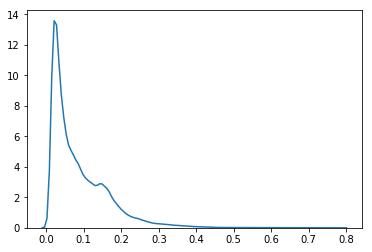

In [4]:
#########################
#   Some visualisation  #
#########################

# Ploting the distribution of the predicted values
sns.kdeplot(prob_goal)
plt.show()

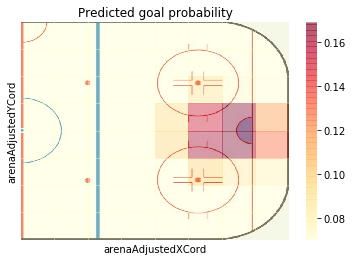

In [5]:
# Preparing the heatmap
hm_data = shots.loc[:,("arenaAdjustedXCord", "arenaAdjustedYCord")]
hm_data["goal"] = prob_goal
hm_data.loc[hm_data.arenaAdjustedXCord < 0, "arenaAdjustedYCord"] = -hm_data.arenaAdjustedYCord
hm_data["arenaAdjustedXCord"]=hm_data["arenaAdjustedXCord"].abs()

binsx = 8
binsy = 8

hm_data=hm_data.groupby([pd.cut(hm_data.arenaAdjustedYCord, binsy), 
                 pd.cut(hm_data.arenaAdjustedXCord, binsx)])["goal"].mean().unstack()

# Ploting the heatmap
plt.clf()
hm = sns.heatmap(hm_data, cmap="YlOrRd", robust = True, yticklabels=False, vmin=0.07,
                   xticklabels=False, alpha = 0.4, zorder = 2)
hm.imshow(rink,
          aspect = hm.get_aspect(),
          extent = hm.get_xlim() + hm.get_ylim(),
          zorder = 1)

plt.title("Predicted goal probability")
plt.show()

In [6]:
############################################
#  getting the average goalie performance  #
############################################

# I get a df with one row per shot
df = shots[["goalie", "goal", "season"]]
df = pd.concat([df, prob_goal], axis=1)
df = df.rename(columns={0:"prob_goal"})

# Grouping by goalie + season
df2 = df.groupby(["goalie", "season"]).agg(["sum", "count"])
df2.columns = df2.columns.droplevel(1)
df2.columns = ["goals", "shots","avg_goalie_goals","x"]
df2 = df2.drop(columns = "x")
df2 = df2.reset_index()

# Computing save shot percentage (svs%) and average goalie svs%
df2["svs%"] = df2["shots"] - df2["goals"]
df2["svs%"] = df2["svs%"]/df2["shots"]

df2["svs%_average"] = df2["shots"] - df2["avg_goalie_goals"]
df2["svs%_average"] = df2["svs%_average"]/df2["shots"]

df2["diff"] = df2["svs%"] - df2["svs%_average"]

# Computing ranks
df2["svs%_rank"] = df2.groupby("season")["svs%"].rank("dense", ascending=False).astype(int)
df2["good_ranking"] = df2.groupby("season")["diff"].rank("dense", ascending=False).astype(int)

df2["rank_gain"] = df2["svs%_rank"] - df2["good_ranking"]

'''

df2 = df2.sort_values("svs%", ascending=False).reset_index(drop=True)
df2["svs%_ranking"] = df2.index+1

df2 = df2.sort_values("diff", ascending=False).reset_index(drop=True)
df2["good_ranking"] = df2.index+1

'''

# Getting the number of game played
games = shots[["goalie", "game_id"]].groupby("goalie").agg(pd.Series.nunique).reset_index()
games = games.rename(columns={"game_id":"games_played"})

df2 = pd.merge(left=df2, right=games, how="left", on="goalie")
# Reputting the goalie name
df2 = pd.merge(left=df2, right=shots[["goalie", "goalieNameForShot"]], how="left", on="goalie")
df2 = df2.drop("goalie", axis=1)
df2 = df2.rename(columns={"goalieNameForShot":"goalie"})

# OUTPUT
df3 = pd.concat([df2["goalie"], df2.iloc[:,:-1]], axis=1)
df3 = df3.sort_values(by=["season", "good_ranking"])
df3 = df3.round({"avg_goalie_goals": 2, "svs%": 4, "svs%_average": 4, "diff": 4})

df3.to_csv("/kaggle/working/rankings.csv", index=False)

df4 = df3.loc[df3["games_played"]>= 24, :]
df4.to_csv("/kaggle/working/rankings_more_than_24_games.csv", index=False)

# SHAP

WORK IN PROGRESS

# Robustness

WORK IN PROGRESS

# Discussion


WORK IN PROGRESS

# Final thoughts
WORK IN PROGRESS